In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTENC

In [73]:
import src
from src import *

In [74]:
data = datasets.data_original()
data.shape


(2139, 23)

In [75]:
data = features.engineer(data)

In [76]:
data.head()

,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,...,cd40,cd420,cd80,cd820,infected,time730,time_censored,trt0,trt1,trt2
0,48,89.8128,0,0,0,100,0,0,0,0,...,422,477,566,324,0,218,0,0,0,1
1,61,49.4424,0,0,0,90,0,1,895,0,...,162,218,392,564,1,272,0,0,0,0
2,45,88.4520,0,1,1,90,0,1,707,0,...,326,274,2063,1893,0,231,0,0,0,0
3,47,85.2768,0,1,0,100,0,1,1399,0,...,287,394,1590,966,0,436,0,0,0,0
4,43,66.6792,0,1,0,100,0,1,1352,0,...,504,353,870,782,0,360,0,1,0,0


In [77]:
# Carico il dataset
df=data
X=df.drop("infected",axis=1)
y=df["infected"]

In [78]:
# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Pipeline for KNN

### Preparation of the pipeline scaler -> oversampler -> knn

In [79]:
# choose the oversampler
cat_features = [c for c in X_train.columns if X_train[c].nunique() < 5]
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)

In [80]:
from src.functions import ScalerWrapper

In [81]:
# choose the scaler
scaler = MinMaxScaler()

# make the scaler retain the column names
scaler_with_columns = ScalerWrapper(scaler,X_train.columns)

In [82]:
# choose the model
knn = KNeighborsClassifier()

# choose the model grid parameters
model_param_grid = {
    'n_neighbors': [3, 5, 7, 11], 
    'metric': ['euclidean', 'manhattan'],
    'weights': ['distance']
}


In [83]:
# make the parameters visible to the model in the pipeline
prefix = 'kneighborsclassifier__' 
imba_param_grid = { prefix + key : value for key,value in model_param_grid.items()}


### Create the grid search optimization

In [84]:
from imblearn.pipeline import Pipeline, make_pipeline

In [85]:
# X_train and X_test should be not scaled and not oversampled

# Build the pipeline
knn_pipeline = make_pipeline(
    scaler_with_columns,
    smote_nc,
    knn
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=imba_param_grid, 
    cv=5, 
    scoring='accuracy')
grid_search.fit(X_train, y_train)


c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalerwrapper',
                                        <src.functions.ScalerWrapper object at 0x000001FCA30F25D0>),
                                       ('smotenc',
                                        SMOTENC(categorical_features=['hemo',
                                                                      'homo',
                                                                      'drugs',
                                                                      'karnof',
                                                                      'oprior',
                                                                      'z30',
                                                                      'race',
                                                                      'gender',
                                                                      'str2',
                                                                      'strat',
                                                                      'symptom',
                                                                      'offtrt',
                                                                      'trt0',
                                                                      'trt1',
                                                                      'trt2'],
                                                random_state=42,
                                                sampling_strategy=1.0)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 11],
                         'kneighborsclassifier__weights': ['distance']},
             scoring='accuracy')

In [86]:

# Best model and evaluation
best_knnR = grid_search.best_estimator_
y_pred = best_knnR.predict(X_test)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cv score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test recall: {recall_score(y_test, y_pred)}')

Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}
Best cv score: 0.8299251530186009
Test accuracy: 0.8551401869158879
Test recall: 0.7029702970297029


## 059-Tune KNN Hyperparameters ##

In [87]:
# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10],'metric': ['euclidean', 'manhattan']}

In [89]:
# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Miglior modello e valutazione
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Best score: 0.8416057149676913
Test accuracy: 0.8411214953271028


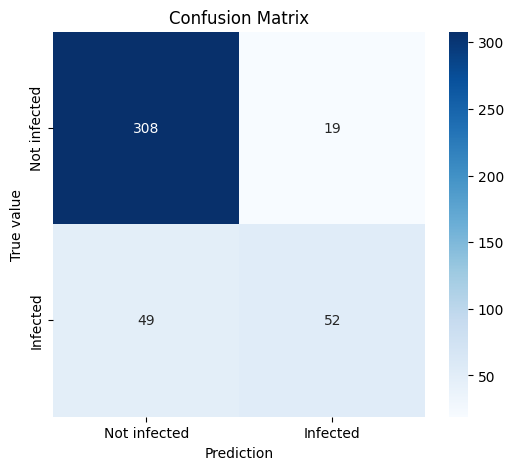

In [90]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

## 060-Cross Validation for KNN ##

In [91]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],'metric': ['euclidean', 'manhattan']}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)
best_knn = grid_search.best_estimator_
cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='accuracy')


print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score(mean): {grid_search.best_score_}')

print(f'cv mean accuracy: {cv_scores.mean()}')
print(f"fold's accuracy: {cv_scores}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Best score(mean): 0.838230208584123
cv mean accuracy: 0.838230208584123
fold's accuracy: [0.85747664 0.81074766 0.84813084 0.86214953 0.81264637]


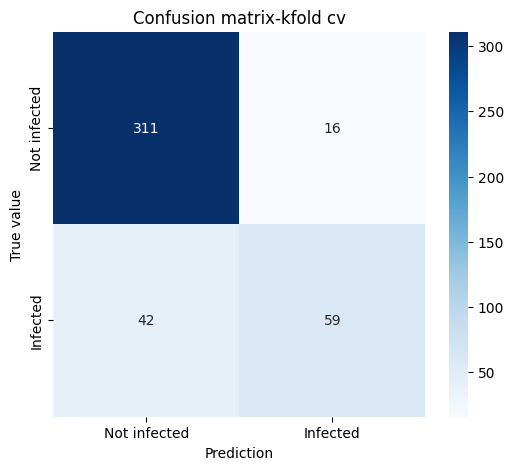

In [92]:
y_pred_cv = best_knn.predict(X_test)
cm_cv = confusion_matrix(y_test, y_pred_cv)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion matrix-kfold cv')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

## MinMaxScaler ##

In [93]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di MinMaxScaler
scaler = MinMaxScaler()
X_train_Mscaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_Mscaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_train.columns)

#oversampling
cat_features = [c for c in X_train.columns if X_train[c].nunique() < 5]
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_Mscaled, y_train) 

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ['euclidean', 'manhattan'],'weights': ['distance']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_oversampled, y_oversampled)

# Miglior modello e valutazione
best_knnM = grid_search.best_estimator_
y_pred = best_knnM.predict(X_test_Mscaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')

c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.8912097221597468
Test accuracy: 0.8598130841121495
test recall: 0.6732673267326733


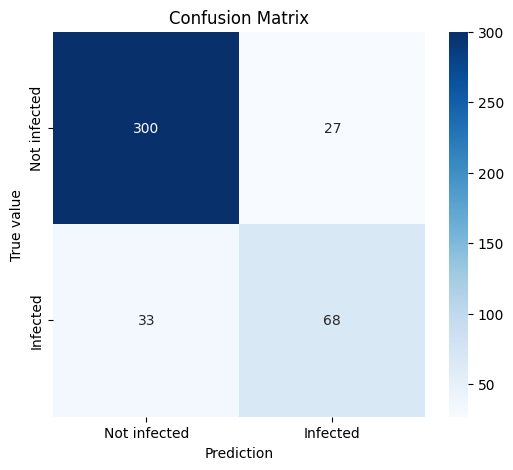

In [94]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

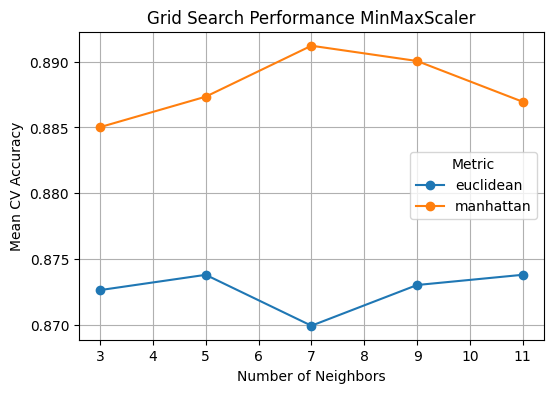

In [95]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance MinMaxScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

## StandardScaler ##

In [96]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di StandardScaler
scaler = StandardScaler()
X_train_Sscaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_Sscaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_train.columns)

#oversampling
cat_features = [c for c in X_train.columns if X_train[c].nunique() < 5]
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_Sscaled, y_train) 

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ['euclidean', 'manhattan'],'weights': ['distance']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_oversampled, y_oversampled)

# Miglior modello e valutazione
best_knnS = grid_search.best_estimator_
y_pred = best_knnS.predict(X_test_Sscaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')

c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.9016523473228075
Test accuracy: 0.8200934579439252
test recall: 0.6831683168316832


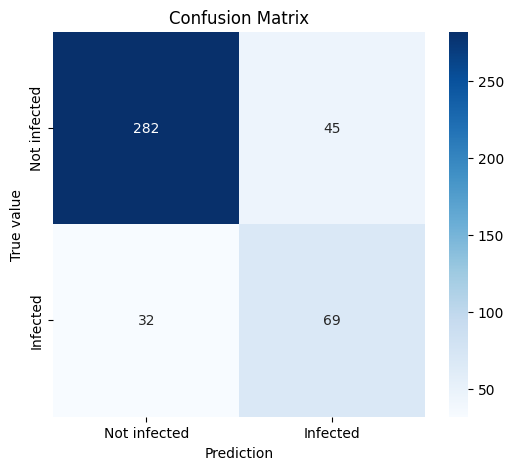

In [97]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

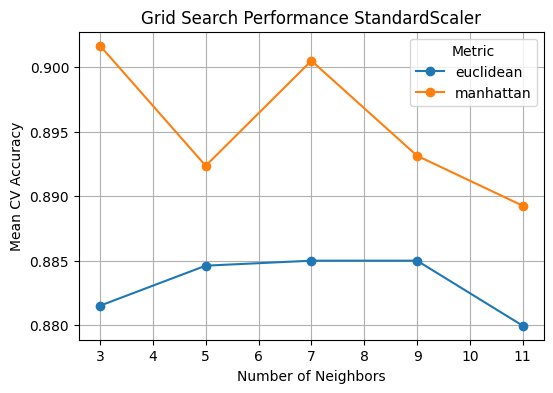

In [98]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance StandardScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

## RobustScaler ##

In [99]:
# Carico il dataset
df = data
X = df.drop("infected", axis=1)
y = df["infected"]

# Suddivisione dei dati in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicazione di RobustScaler
scaler = RobustScaler()
X_train_Rscaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_Rscaled = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

#oversampling
cat_features = [c for c in X_train.columns if X_train[c].nunique() < 5]
smote_nc = SMOTENC(categorical_features=cat_features, sampling_strategy=1.0, random_state=42)
X_oversampled, y_oversampled = smote_nc.fit_resample(X_train_Rscaled, y_train) 

# Creazione del modello KNN e definizione dei parametri
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ['euclidean', 'manhattan'],'weights': ['distance']}

# Grid Search con Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_oversampled, y_oversampled)

# Miglior modello e valutazione
best_knnR = grid_search.best_estimator_
y_pred = best_knnR.predict(X_test_Rscaled)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'test recall: {recall_score(y_test, y_pred)}')

c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best score: 0.8981542290795135
Test accuracy: 0.8060747663551402
test recall: 0.7128712871287128


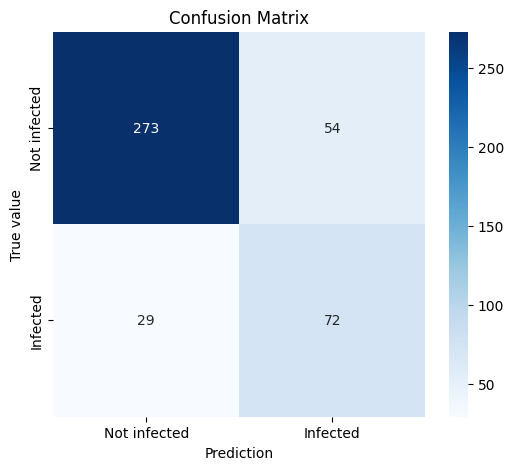

In [100]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not infected', 'Infected'], yticklabels=['Not infected', 'Infected'])
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.show()

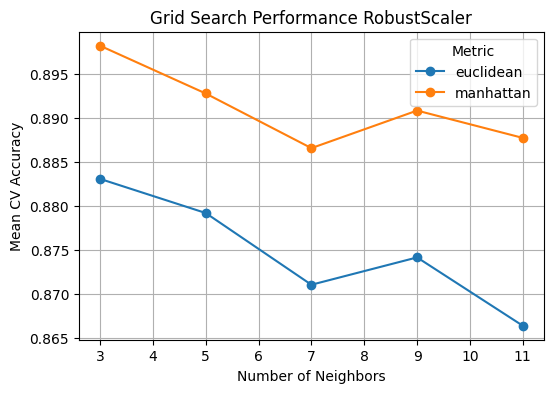

In [101]:
# Creazione del dataframe con i risultati della grid search
results = pd.DataFrame(grid_search.cv_results_)

# Line plot per visualizzare la variazione dell'accuratezza rispetto a 'n_neighbors' per ciascuna metrica
plt.figure(figsize=(6, 4))
for metric in results['param_metric'].unique():
    subset = results[results['param_metric'] == metric]
    plt.plot(subset['param_n_neighbors'], subset['mean_test_score'], label=metric, marker='o')

# Configurazione del grafico
plt.title('Grid Search Performance RobustScaler')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean CV Accuracy')
plt.legend(title='Metric')
plt.grid()
plt.show()

In [102]:
model_knnR = best_knn
X_knn_train = X_train_Rscaled
X_knn_test = X_test_Rscaled
model_knnR.fit(X_knn_train,y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

In [103]:
import pickle

model = model_knnR
filename = "models/knn.pkl"
file = open(filename, "wb")
pickle.dump(model, file)
file.close()

### test pipeline ###

In [104]:
# choose the scaler
scaler = MinMaxScaler()

# make the scaler retain the column names
scaler_with_columns = ScalerWrapper(scaler,X_train.columns)

In [105]:
# X_train and X_test should be not scaled and not oversampled

# Build the pipeline
knn_pipeline = make_pipeline(
    scaler_with_columns,
    smote_nc,
    knn
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=imba_param_grid, 
    cv=5, 
    scoring='accuracy')
grid_search.fit(X_train, y_train)


c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalerwrapper',
                                        <src.functions.ScalerWrapper object at 0x000001FCA42C0050>),
                                       ('smotenc',
                                        SMOTENC(categorical_features=['hemo',
                                                                      'homo',
                                                                      'drugs',
                                                                      'karnof',
                                                                      'oprior',
                                                                      'z30',
                                                                      'race',
                                                                      'gender',
                                                                      'str2',
                                                                      'strat',
                                                                      'symptom',
                                                                      'offtrt',
                                                                      'trt0',
                                                                      'trt1',
                                                                      'trt2'],
                                                random_state=42,
                                                sampling_strategy=1.0)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 11],
                         'kneighborsclassifier__weights': ['distance']},
             scoring='accuracy')

In [106]:

# Best model and evaluation
best_knnR = grid_search.best_estimator_
y_pred = best_knnR.predict(X_test)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cv score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test recall: {recall_score(y_test, y_pred)}')

Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}
Best cv score: 0.8299251530186009
Test accuracy: 0.8551401869158879
Test recall: 0.7029702970297029


### standard ###

In [107]:
# choose the scaler
scaler = StandardScaler()

# make the scaler retain the column names
scaler_with_columns = ScalerWrapper(scaler,X_train.columns)

In [108]:
# X_train and X_test should be not scaled and not oversampled

# Build the pipeline
knn_pipeline = make_pipeline(
    scaler_with_columns,
    smote_nc,
    knn
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=imba_param_grid, 
    cv=5, 
    scoring='accuracy')
grid_search.fit(X_train, y_train)


c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalerwrapper',
                                        <src.functions.ScalerWrapper object at 0x000001FC8DCB3710>),
                                       ('smotenc',
                                        SMOTENC(categorical_features=['hemo',
                                                                      'homo',
                                                                      'drugs',
                                                                      'karnof',
                                                                      'oprior',
                                                                      'z30',
                                                                      'race',
                                                                      'gender',
                                                                      'str2',
                                                                      'strat',
                                                                      'symptom',
                                                                      'offtrt',
                                                                      'trt0',
                                                                      'trt1',
                                                                      'trt2'],
                                                random_state=42,
                                                sampling_strategy=1.0)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 11],
                         'kneighborsclassifier__weights': ['distance']},
             scoring='accuracy')

In [109]:

# Best model and evaluation
best_knnR = grid_search.best_estimator_
y_pred = best_knnR.predict(X_test)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cv score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test recall: {recall_score(y_test, y_pred)}')

Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Best cv score: 0.8258179462261095
Test accuracy: 0.8200934579439252
Test recall: 0.6435643564356436


### robust ###

In [110]:
# choose the scaler
scaler = RobustScaler()

# make the scaler retain the column names
scaler_with_columns = ScalerWrapper(scaler,X_train.columns)

In [111]:
# X_train and X_test should be not scaled and not oversampled

# Build the pipeline
knn_pipeline = make_pipeline(
    scaler_with_columns,
    smote_nc,
    knn
)

# Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=knn_pipeline, 
    param_grid=imba_param_grid, 
    cv=5, 
    scoring='accuracy')
grid_search.fit(X_train, y_train)


c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\alexa\Desktop\progetto\ProgettoTeam2\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scalerwrapper',
                                        <src.functions.ScalerWrapper object at 0x000001FCA42C2D50>),
                                       ('smotenc',
                                        SMOTENC(categorical_features=['hemo',
                                                                      'homo',
                                                                      'drugs',
                                                                      'karnof',
                                                                      'oprior',
                                                                      'z30',
                                                                      'race',
                                                                      'gender',
                                                                      'str2',
                                                                      'strat',
                                                                      'symptom',
                                                                      'offtrt',
                                                                      'trt0',
                                                                      'trt1',
                                                                      'trt2'],
                                                random_state=42,
                                                sampling_strategy=1.0)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__metric': ['euclidean',
                                                          'manhattan'],
                         'kneighborsclassifier__n_neighbors': [3, 5, 7, 11],
                         'kneighborsclassifier__weights': ['distance']},
             scoring='accuracy')

In [112]:

# Best model and evaluation
best_knnR = grid_search.best_estimator_
y_pred = best_knnR.predict(X_test)

# Risultati
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cv score: {grid_search.best_score_}')
print(f'Test accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test recall: {recall_score(y_test, y_pred)}')

Best parameters: {'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 5, 'kneighborsclassifier__weights': 'distance'}
Best cv score: 0.8129729084616303
Test accuracy: 0.8130841121495327
Test recall: 0.7227722772277227


In [118]:
#with open('models/knnpipeline.pkl', 'wb') as file:
    #pickle.dump(best_knnR, file)